In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 465 kB 57.9 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

df = pd.read_excel("/content/gdrive/MyDrive/Colab Notebooks/ai/식품/dataset.xlsx")
X= pd.DataFrame({ 'Name' : df.iloc[:,0] })
y= pd.DataFrame({ 'S' : df.iloc[0:,2] })

In [ ]:
import re
from konlpy.tag import Okt  
okt=Okt()  
sub_dic = [] ; dic = {} ; lst = []
for i, item in enumerate(list(X.iloc[:,0])):
    sub_str = re.sub('[a-zA-Z0-9]', "", item)
    X.iloc[i,0] = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z]", "", sub_str)
    X.iloc[i,0] = okt.normalize(X.iloc[i,0])
    X.iloc[i,0] = okt.nouns(X.iloc[i,0])
    Max = max(len(X.iloc[i,0]), len(X.iloc[i-1,0]))
    sub_dic.extend(X.iloc[i,0])

sub_dic = list(set(sub_dic))

for i, item in enumerate(sub_dic):
  dic[item] = i

for i, item in enumerate(list(X.iloc[:,0])):
  for j in item:
    lst.append(dic[j])
  X.iloc[i,0] = lst
  lst = []
print(X)

                                                 Name
0                    [75, 149, 70, 111, 112, 140, 55]
1           [78, 108, 181, 122, 140, 55, 102, 87, 64]
2                              [182, 162, 32, 33, 65]
3                         [175, 42, 185, 122, 87, 16]
4                                 [140, 87, 177, 173]
..                                                ...
75                            [53, 125, 149, 150, 84]
76  [186, 9, 188, 91, 177, 125, 150, 84, 81, 125, ...
77  [120, 125, 192, 125, 0, 113, 189, 39, 178, 7, 92]
78              [76, 100, 48, 17, 89, 29, 48, 33, 99]
79  [186, 9, 188, 91, 177, 125, 150, 84, 81, 125, ...

[80 rows x 1 columns]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence

label = y.iloc[:,0].unique()
for i,item in enumerate(label):
  y = y.replace(item,i)
y = tf.keras.utils.to_categorical(y,2)

X = sequence.pad_sequences(X.iloc[:,0], maxlen = 14)

In [ ]:
y[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

def jpg_image_to_array(image_path,size):
  image = Image.open(image_path)
  image = image.resize((size,size))
  im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
  im_arr = im_arr.reshape((image.size[1], image.size[0], 3))
  return im_arr

dir = '/content/gdrive/MyDrive/Colab Notebooks/ai/식품/사과,배'

subdir_names = os.listdir(dir)
X_img = [] ; y_img = []
for subdir_name in subdir_names:
  subdir = dir + "/" + subdir_name
  file_names = os.listdir(subdir)
  for file_name in file_names:
    path = subdir + "/" + file_name
    arr = jpg_image_to_array(path, 224)
    if len(X_img)==0:
      X_img = [arr]
      y_img.append(subdir_name)

    else:
      X_img = np.concatenate((X_img, [arr]))
      y_img.append(subdir_name)


print(X_img.shape)
print(len(y_img))


<ipython-input-8-d3b985e779b4>:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)


(80, 224, 224, 3)
80


In [ ]:
X_img = X_img/255

In [ ]:
y_img = pd.DataFrame(y_img, dtype='str')
label = y_img.iloc[:,0].unique()
for i,item in enumerate(label):
  y_img = y_img.replace(item,i)
y_img = tf.keras.utils.to_categorical(y_img,2)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=77)
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(X_img, y_img, stratify=y, test_size=0.25, random_state=77)

In [ ]:
for i, j in zip(y, y_img):
  if i[0] == j[0]:
    continue
  else:
    print(i, j)
    print('타겟 데이터가 다른 record끼리 연결되었습니다.')
    break

In [ ]:
model_CS = tf.keras.Sequential()
model_CS.add(layers.Conv1D(filters=16, kernel_size=2, strides=1, padding='same', 
                        activation='relu',input_shape=(14,1)))
model_CS.add(layers.LSTM(64))
model_CS.add(layers.Dense(2, activation='sigmoid'))

model_CS.compile(loss=tf.keras.losses.binary_crossentropy, 
              optimizer= tf.keras.optimizers.RMSprop(0.001),
              metrics = ['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
hist_CS = model_CS.fit(X_train,y_train,
          batch_size=3,
          epochs=100,
          validation_split=0.1,
          callbacks=[early_stop],
          shuffle=True,
          verbose=1)

Epoch 1/100
18/18 [==============================] - 5s 77ms/step - loss: 0.7386 - accuracy: 0.5185 - val_loss: 0.7515 - val_accuracy: 0.3333
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 0.6562 - accuracy: 0.5926 - val_loss: 0.8278 - val_accuracy: 0.3333
Epoch 3/100
18/18 [==============================] - 0s 9ms/step - loss: 0.6396 - accuracy: 0.6852 - val_loss: 0.8293 - val_accuracy: 0.5000
Epoch 4/100
18/18 [==============================] - 0s 10ms/step - loss: 0.6042 - accuracy: 0.7222 - val_loss: 0.8577 - val_accuracy: 0.3333
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 0.5886 - accuracy: 0.6852 - val_loss: 0.8860 - val_accuracy: 0.3333
Epoch 6/100
18/18 [==============================] - 0s 9ms/step - loss: 0.5650 - accuracy: 0.6481 - val_loss: 0.9985 - val_accuracy: 0.1667


In [ ]:
import tensorflow_hub as hub

url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2'
model_CNN= tf.keras.Sequential([
    hub.KerasLayer(handle = url, input_shape = (224, 224, 3), trainable = False)])
model_CNN.add(layers.Flatten())
model_CNN.add(layers.Dense(2, activation='sigmoid'))

model_CNN.compile(loss=tf.keras.losses.categorical_crossentropy, 
              optimizer= tf.keras.optimizers.RMSprop(0.001),
              metrics = ['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
hist_CNN = model_CNN.fit(X_train_img,y_train_img,
          batch_size=3,
          epochs=100,
          validation_split=0.1,
          callbacks = early_stop,
          shuffle=True,
          verbose=1)

Epoch 1/100
18/18 [==============================] - 11s 198ms/step - loss: 0.4779 - accuracy: 0.8148 - val_loss: 0.3363 - val_accuracy: 0.6667
Epoch 2/100
18/18 [==============================] - 2s 128ms/step - loss: 0.0802 - accuracy: 0.9815 - val_loss: 0.1108 - val_accuracy: 1.0000
Epoch 3/100
18/18 [==============================] - 2s 127ms/step - loss: 0.0301 - accuracy: 1.0000 - val_loss: 0.0801 - val_accuracy: 1.0000
Epoch 4/100
18/18 [==============================] - 3s 193ms/step - loss: 0.0132 - accuracy: 1.0000 - val_loss: 0.1222 - val_accuracy: 1.0000
Epoch 5/100
18/18 [==============================] - 3s 173ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0280 - val_accuracy: 1.0000
Epoch 6/100
18/18 [==============================] - 2s 121ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0745 - val_accuracy: 1.0000
Epoch 7/100
18/18 [==============================] - 2s 125ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0152 - val_accuracy: 1.000

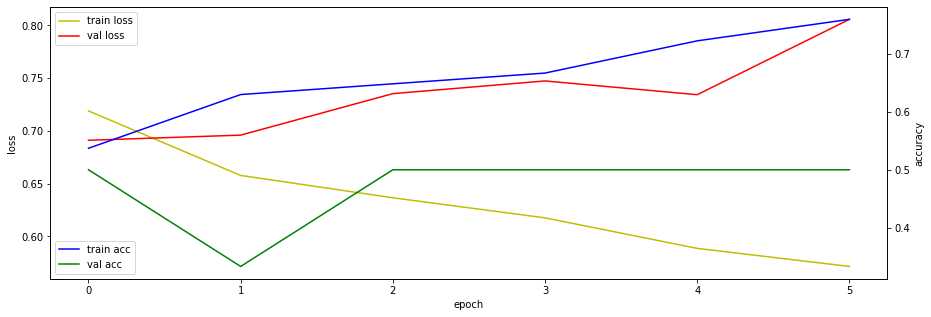

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(15,5))
acc_ax = loss_ax.twinx()

loss_ax.plot(hist_CS.history['loss'],'y', label = 'train loss')
loss_ax.plot(hist_CS.history['val_loss'],'r', label = 'val loss')
acc_ax.plot(hist_CS.history['accuracy'],'b', label = 'train acc')
acc_ax.plot(hist_CS.history['val_accuracy'],'g', label = 'val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

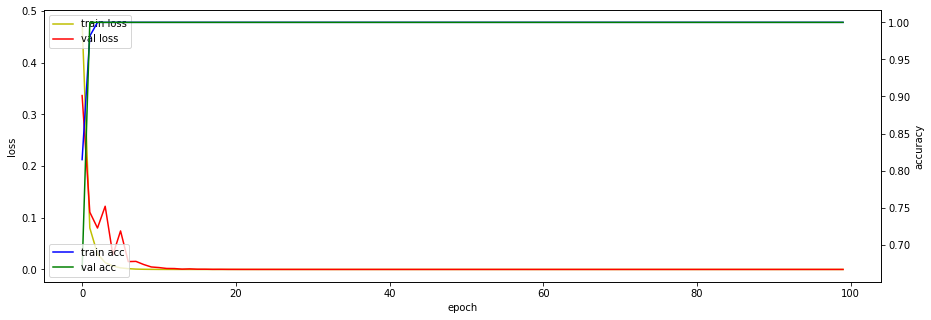

In [ ]:
fig, loss_ax = plt.subplots(figsize=(15,5))
acc_ax = loss_ax.twinx()

loss_ax.plot(hist_CNN.history['loss'],'y', label = 'train loss')
loss_ax.plot(hist_CNN.history['val_loss'],'r', label = 'val loss')
acc_ax.plot(hist_CNN.history['accuracy'],'b', label = 'train acc')
acc_ax.plot(hist_CNN.history['val_accuracy'],'g', label = 'val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
score_CS = model_CS.evaluate(X_test, y_test)
score_CNN = model_CNN.evaluate(X_test_img, y_test_img)
print('test_loss : ' , score_CNN[0], 'test_acc :' , score_CNN[1])
print('test_loss : ' , score_CS[0], 'test_acc :' , score_CS[1])

1/1 [==============================] - 1s 1s/step - loss: 3.2857e-05 - accuracy: 1.0000
test_loss :  3.285749698989093e-05 test_acc : 1.0
test_loss :  0.7507456541061401 test_acc : 0.6000000238418579
